This notebook provides examples to go along with the [textbook](https://underactuated.csail.mit.edu/acrobot.html).  I recommend having both windows open, side-by-side!


In [1]:
import math

import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import HTML, display
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ControllabilityMatrix,
    DiagramBuilder,
    MultibodyPositionToGeometryPose,
    DirectCollocation,
    Linearize,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    Parser,
    Demultiplexer,
    PiecewisePolynomial,
    Multiplexer,
    Saturation,
    SceneGraph,
    LeafSystem,
    Simulator,
    StartMeshcat,
    WrapToSystem,
    TrajectorySource,
    PlanarSceneGraphVisualizer,
)
from pydrake.examples import (
    AcrobotGeometry,
    AcrobotInput,
    AcrobotPlant,
    AcrobotState,
    QuadrotorGeometry,
    QuadrotorPlant,
    StabilizingLQRController,
)
from pydrake.solvers import MathematicalProgram, Solve

from underactuated import ConfigureParser, running_as_notebook
from underactuated.meshcat_utils import MeshcatSliders
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer

if running_as_notebook:
    mpld3.enable_notebook()

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://739597dc-ec98-4db8-aeae-15a1407bbf32.deepnoteproject.com/7000/


In [3]:
import numpy as np
from pydrake.all import (
    DiagramBuilder,
    MultibodyPlant,
    Parser,
    Propeller,
    PropellerInfo,
    RigidTransform,
)
from pydrake.examples import QuadrotorPlant

from underactuated.scenarios import AddFloatingRpyJoint
mass = 0.775

def MakeMultibodyQuadrotor():
    builder = DiagramBuilder()
    # The MultibodyPlant handles f=ma, but doesn't know about propellers.
    plant = builder.AddSystem(MultibodyPlant(0.0))
    #scene_graph = builder.AddSystem(SceneGraph())
    #plant, scene_graph  = AddMultibodyPlantSceneGraph(builder, time_step = 0.0)
    parser = Parser(plant)
    ConfigureParser(parser)
    (model_instance,) = parser.AddModelsFromUrl(
        "package://drake/examples/quadrotor/quadrotor.urdf"
    )

    
    # By default the multibody has a quaternion floating base.  To match
    # QuadrotorPlant, we can manually add a FloatingRollPitchYaw joint. We set
    # `use_ball_rpy` to false because the BallRpyJoint uses angular velocities
    # instead of ṙ, ṗ, ẏ.
    AddFloatingRpyJoint(
        plant,
        plant.GetFrameByName("base_link"),
        model_instance,
        use_ball_rpy=False,
    )
    plant.Finalize()
    
    # Now we can add in propellers as an external force on the MultibodyPlant.
    body_index = plant.GetBodyByName("base_link").index()
    # Default parameters from quadrotor_plant.cc:
    L = 0.15  # Length of the arms (m).
    kF = 1.0  # Force input constant.
    kM = 0.0245  # Moment input constant.

    # Note: Rotors 0 and 2 rotate one way and rotors 1 and 3 rotate the other.
    prop_info = [
        PropellerInfo(body_index, RigidTransform([L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, L, 0]), kF, -kM),
        PropellerInfo(body_index, RigidTransform([-L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, -L, 0]), kF, -kM),
    ]
    propellers = builder.AddSystem(Propeller(prop_info))
    builder.Connect(
        propellers.get_output_port(),
        plant.get_applied_spatial_force_input_port(),
    )
    builder.Connect(
        plant.get_body_poses_output_port(),
        propellers.get_body_poses_input_port(),
    )
    builder.ExportInput(propellers.get_command_input_port(), "u")
    builder.ExportOutput(plant.get_state_output_port(), "state")
    return builder.Build(), plant

def getLQR(small_plant):
    Q = np.diag((10., 10., 10., 10., 10., 10.,1., 1., 1., 1., 1., 1.))
    R = np.eye(4)
    quadrotor_context = small_plant.CreateDefaultContext()
    target_state = np.zeros(12)
    target_state[2] = 0.5
    target_state[3] = np.pi/10
    #state goes x y z r p y dx dy dx dr dp dy
    quadrotor_context.SetContinuousState(target_state)#fix target state
    small_plant.get_input_port(0).FixValue(quadrotor_context,[mass*9.81/4]*4) #fix target input (u) TODO: modify if payload
    controller = LinearQuadraticRegulator(small_plant, quadrotor_context, Q, R, input_port_index=0)
    return controller

def simulateMultibodyQuadrotor():
    larger_builder = DiagramBuilder()
    diagram, plant = MakeMultibodyQuadrotor()
    quadcopter = larger_builder.AddSystem(diagram)#add smaller quadcopter builder to larger one
    scene_graph = larger_builder.AddSystem(SceneGraph())

    meshcat.Delete()
    meshcat.ResetRenderMode()
    meshcat.SetProperty("/Background", "visible", False)
    MeshcatVisualizer.AddToBuilder(larger_builder, scene_graph, meshcat)
    
    #12 states, 4 input ports
    controller = larger_builder.AddSystem(getLQR(quadcopter))
    larger_builder.Connect(quadcopter.get_output_port(0), controller.get_input_port(0))
    larger_builder.Connect(controller.get_output_port(0), quadcopter.get_input_port(0))
    QuadrotorGeometry.AddToBuilder(larger_builder, quadcopter.get_output_port(0), scene_graph)

    large_diagram = larger_builder.Build()
    # Set up a simulator to run this diagram
    simulator = Simulator(large_diagram)
    simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0.0)
    context = simulator.get_mutable_context()


    # Simulate
    for i in range(5):
        context.SetTime(0.0)
        context.SetContinuousState(
            0.5
            * np.random.randn(
                12,
            )
        )
        simulator.Initialize()
        simulator.AdvanceTo(4.0 if running_as_notebook else 0.1)
#simulateMultibodyQuadrotor()

starting guess (interpolate point a and point b). Start with (for example) origin and 0,0,1, don't forget to zero derivatives

create the program, set number of timestamps, create cost function, create constraints on thrust/anything else, solve it. Decision variables is input to motors (u*t). To do transcription record 12*t states, apply relevant constraints to avoid collisions

plug u back into simulator and run it

future: add pin joint and don't swing payload around

use trajopt and have it guide one drone, then have n other drones follow it around

In [4]:
def quad_dircol():
    larger_builder = DiagramBuilder()
    diagram, plant = MakeMultibodyQuadrotor()
    quadcopter = larger_builder.AddSystem(diagram)#add smaller quadcopter builder to larger one
    scene_graph = larger_builder.AddSystem(SceneGraph())
    context = diagram.CreateDefaultContext()

    N = 21
    max_dt = 0.5
    N * max_dt
    dircol = DirectCollocation(
        diagram,
        context,
        num_time_samples=N,
        minimum_timestep=0.05,
        maximum_timestep=max_dt,
        input_port_index=diagram.get_input_port(0).get_index(),
    )
    prog = dircol.prog()

    dircol.AddEqualTimeIntervalsConstraints()

    thrust_limit = 3.0  # N*m.
    u = dircol.input()
    initial_state = np.zeros(12)
    target_state = np.zeros(12)
    target_state[1] = 3
    target_state[2] = 3
    prog.AddBoundingBoxConstraint(
        initial_state, initial_state,
        dircol.initial_state(),
    )
    for i in range(4):
        dircol.AddConstraintToAllKnotPoints(u[i] <= 4)
    

    prog.AddBoundingBoxConstraint(
        target_state, target_state, dircol.final_state()
    )

    R = 10  # Cost on input "effort".
    dircol.AddRunningCost(R * (u[0] ** 2 + u[1] ** 2 + u[2] ** 2 + u[3] ** 2))
    dircol.AddFinalCost(dircol.time())

    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0.0, 4.0], np.column_stack((initial_state, target_state))
    )
    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

    result = Solve(prog)
    assert result.is_success()

    x_trajectory = dircol.ReconstructStateTrajectory(result)

    fig, ax = plt.subplots()

    x_knots = np.hstack(
        [
            x_trajectory.value(t)
            for t in np.linspace(
                x_trajectory.start_time(), x_trajectory.end_time(), 100
            )
        ]
    )
    ax.set_xlabel("$q$")
    ax.set_ylabel("$\dot{q}$")
    ax.plot(x_knots[2, :], x_knots[8, :])
    display(plt.show())

    u_trajectory = dircol.ReconstructInputTrajectory(result)

    meshcat.Delete()
    meshcat.ResetRenderMode()
    meshcat.SetProperty("/Background", "visible", False)
    MeshcatVisualizer.AddToBuilder(larger_builder, scene_graph, meshcat)
    
    source = larger_builder.AddSystem(TrajectorySource(u_trajectory))
    #12 states, 4 input ports
    larger_builder.Connect(source.get_output_port(0), quadcopter.get_input_port(0))
    QuadrotorGeometry.AddToBuilder(larger_builder, quadcopter.get_output_port(0), scene_graph)

    large_diagram = larger_builder.Build()
    # Set up a simulator to run this diagram
    simulator = Simulator(large_diagram)
    simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0.0)
    context = simulator.get_mutable_context()

    # Simulate
    for i in range(5):
        context.SetTime(0.0)
        context.SetContinuousState(initial_state)
        simulator.Initialize()
        print("arrived in: "+str(x_trajectory.end_time()))
        simulator.AdvanceTo(x_trajectory.end_time() if running_as_notebook else 0.1)






#quad_dircol()

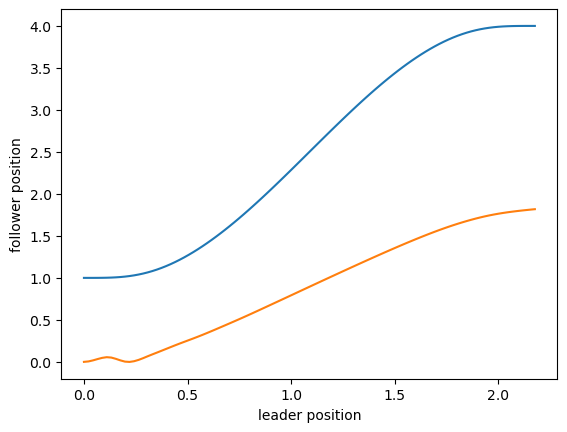

None

In [31]:

two_copter_builder = DiagramBuilder()
diagram, plant = MakeMultibodyQuadrotor()
quadcopter = two_copter_builder.AddSystem(diagram)#add smaller quadcopter builder to larger one
diagram2, plant2 = MakeMultibodyQuadrotor()
quadcopter2 = two_copter_builder.AddSystem(diagram2)

input_converter = two_copter_builder.AddSystem(Demultiplexer(8,4)) #wires diagram input to copter inputs
output_converter = two_copter_builder.AddSystem(Multiplexer([12,12]))
two_copter_builder.Connect(
    input_converter.get_output_port(0),
    quadcopter.get_input_port(0),
)
two_copter_builder.Connect(
    input_converter.get_output_port(1),
    quadcopter2.get_input_port(0),
)
two_copter_builder.Connect(
    quadcopter.get_output_port(0),
    output_converter.get_input_port(0),
)
two_copter_builder.Connect(
    quadcopter2.get_output_port(0),
    output_converter.get_input_port(1),
)
two_copter_builder.ExportInput(input_converter.get_input_port(0), "u_both")
two_copter_builder.ExportOutput(output_converter.get_output_port(0), "state_both")
#two_copter_builder.ExportOutput(quadcopter.get_output_port(0), "state_1")
#two_copter_builder.ExportOutput(quadcopter2.get_output_port(0), "state_2")
two_copter_diagram = two_copter_builder.Build()

larger_builder = DiagramBuilder()
pair = larger_builder.AddSystem(two_copter_diagram)
scene_graph = larger_builder.AddSystem(SceneGraph())
context = two_copter_diagram.CreateDefaultContext()

N = 21
max_dt = 0.5
N * max_dt
dircol = DirectCollocation(
    two_copter_diagram,
    context,
    num_time_samples=N,
    minimum_timestep=0.05,
    maximum_timestep=max_dt,
    input_port_index=two_copter_diagram.get_input_port(0).get_index(),
)
prog = dircol.prog()

dircol.AddEqualTimeIntervalsConstraints()

thrust_limit = 3.0  # N*m.
u = dircol.input()
initial_state = np.zeros(24)
initial_state[0]=1
target_state = np.zeros(24)
target_state[0] = 4
target_state[12] = 1
padding_copter2 = np.zeros(24)
for i in range(12,24):
    padding_copter2[i]=5
prog.AddBoundingBoxConstraint(
    initial_state, initial_state,
    dircol.initial_state(),
)
prog.AddBoundingBoxConstraint(
    target_state-padding_copter2, target_state+padding_copter2, dircol.final_state()
)
for i in range(4):
    dircol.AddConstraintToAllKnotPoints(u[i] <= 2)
    dircol.AddConstraintToAllKnotPoints(u[i] >= -2)
for i in range(4,8):
    dircol.AddConstraintToAllKnotPoints(u[i] <= 100)
    dircol.AddConstraintToAllKnotPoints(u[i] >= -100)
dircol.AddConstraintToAllKnotPoints(np.abs(np.sum(dircol.state()[0:3]-dircol.state()[12:15]))>=0.5)

dircol.AddRunningCost(10*(np.sum(dircol.state()[0:3]-dircol.state()[12:15])**2))
#mod, try quadratic cost
cost1 = 10  # Cost on input "effort".
cost2=1
#leader cost
dircol.AddRunningCost(cost1 * (u[0] ** 2 + u[1] ** 2 + u[2] ** 2 + u[3] ** 2))
#follower cost
#dircol.AddRunningCost(cost2 * (u[4] ** 2 + u[5] ** 2 + u[6] ** 2 + u[7] ** 2))
dircol.AddFinalCost(dircol.time())

initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
    [0.0, 4.0], np.column_stack((initial_state, target_state))
)
dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

result = Solve(prog)
assert result.is_success()

x_trajectory = dircol.ReconstructStateTrajectory(result)

fig, ax = plt.subplots()
time = np.linspace(x_trajectory.start_time(), x_trajectory.end_time(), 100)
x_knots = np.hstack(
    [
        x_trajectory.value(t)
        for t in time
    ]
)
ax.set_xlabel("leader position")
ax.set_ylabel("follower position")
ax.plot(time, x_knots[0, :])
ax.plot(time, x_knots[12, :])
display(plt.show())

u_trajectory = dircol.ReconstructInputTrajectory(result)

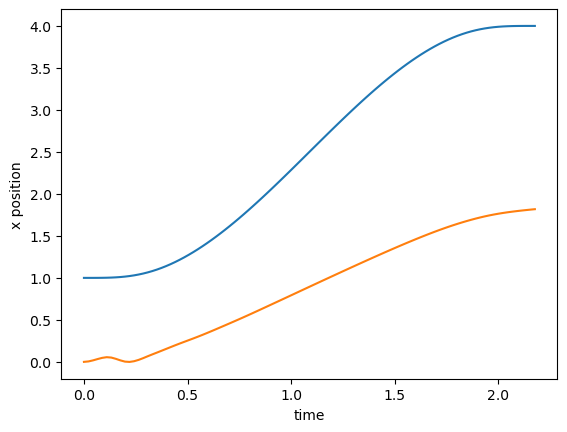

None

In [32]:

fig, ax = plt.subplots()
time = np.linspace(x_trajectory.start_time(), x_trajectory.end_time(), 100)
x_knots = np.hstack(
    [
        x_trajectory.value(t)
        for t in time
    ]
)
ax.set_xlabel("time")
ax.set_ylabel("x position")
ax.plot(time, x_knots[0, :])
ax.plot(time, x_knots[12, :])
display(plt.show())

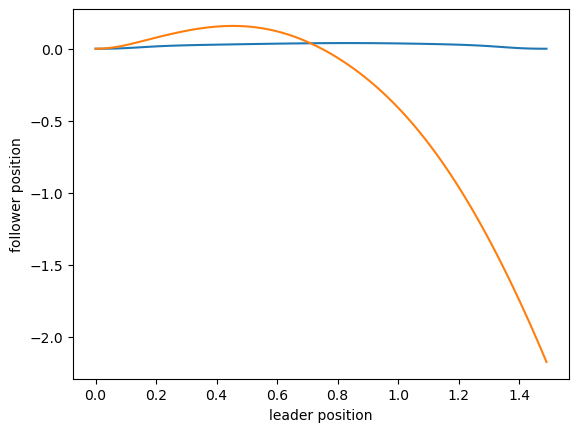

None

In [23]:
fig, ax = plt.subplots()
time = np.linspace(x_trajectory.start_time(), x_trajectory.end_time(), 100)
x_knots = np.hstack(
    [
        x_trajectory.value(t)
        for t in time
    ]
)
ax.set_xlabel("leader position")
ax.set_ylabel("follower position")
ax.plot(time, x_knots[, :])
ax.plot(time, x_knots[12, :])
display(plt.show())

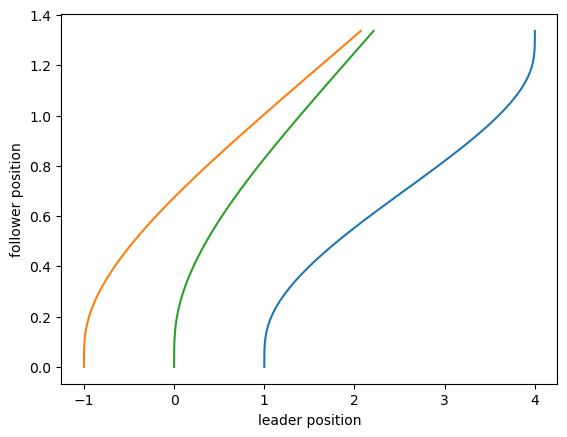

None

In [33]:
two_copter_builder = DiagramBuilder()
diagram, plant = MakeMultibodyQuadrotor()
quadcopter = two_copter_builder.AddSystem(diagram)#add smaller quadcopter builder to larger one
diagram2, plant2 = MakeMultibodyQuadrotor()
quadcopter2 = two_copter_builder.AddSystem(diagram2)
diagram3, plant3 = MakeMultibodyQuadrotor()
quadcopter3 = two_copter_builder.AddSystem(diagram3)

input_converter = two_copter_builder.AddSystem(Demultiplexer(12,4)) #wires diagram input to copter inputs
output_converter = two_copter_builder.AddSystem(Multiplexer([12,12,12]))
two_copter_builder.Connect(
    input_converter.get_output_port(0),
    quadcopter.get_input_port(0),
)
two_copter_builder.Connect(
    input_converter.get_output_port(1),
    quadcopter2.get_input_port(0),
)
two_copter_builder.Connect(
    input_converter.get_output_port(2),
    quadcopter3.get_input_port(0),
)

two_copter_builder.Connect(
    quadcopter.get_output_port(0),
    output_converter.get_input_port(0),
)
two_copter_builder.Connect(
    quadcopter2.get_output_port(0),
    output_converter.get_input_port(1),
)
two_copter_builder.Connect(
    quadcopter2.get_output_port(0),
    output_converter.get_input_port(2),
)
two_copter_builder.ExportInput(input_converter.get_input_port(0), "u_both")
two_copter_builder.ExportOutput(output_converter.get_output_port(0), "state_both")
#two_copter_builder.ExportOutput(quadcopter.get_output_port(0), "state_1")
#two_copter_builder.ExportOutput(quadcopter2.get_output_port(0), "state_2")
two_copter_diagram = two_copter_builder.Build()

larger_builder = DiagramBuilder()
pair = larger_builder.AddSystem(two_copter_diagram)
scene_graph = larger_builder.AddSystem(SceneGraph())
context = two_copter_diagram.CreateDefaultContext()

N = 21
max_dt = 0.5
N * max_dt
dircol = DirectCollocation(
    two_copter_diagram,
    context,
    num_time_samples=N,
    minimum_timestep=0.05,
    maximum_timestep=max_dt,
    input_port_index=two_copter_diagram.get_input_port(0).get_index(),
)
prog = dircol.prog()

dircol.AddEqualTimeIntervalsConstraints()

u = dircol.input()
initial_state = np.zeros(36)
initial_state[0]=1
initial_state[12]=-1
initial_state[25]=1
target_state = np.zeros(36)
target_state[0] = 4
padding_copter2 = np.zeros(36)
for i in range(12,36):
    padding_copter2[i]=6
prog.AddBoundingBoxConstraint(
    initial_state, initial_state,
    dircol.initial_state(),
)
prog.AddBoundingBoxConstraint(
    target_state-padding_copter2, target_state+padding_copter2, dircol.final_state()
)
dircol.AddConstraintToAllKnotPoints(np.abs(np.sum(dircol.state()[0:3]-dircol.state()[12:15]))>=0.5)

#dircol.AddConstraintToAllKnotPoints(np.abs(np.sum(dircol.state()[24:27]-dircol.state()[12:15]))>=0.5)
#dircol.AddConstraintToAllKnotPoints(np.sum(np.abs(dircol.state()[0:3]-dircol.state()[24:27]))>=1)
#dircol.AddConstraintToAllKnotPoints(np.sum(np.abs(dircol.state()[12:15]-dircol.state()[24:27]))>=1)
#dircol.AddConstraintToAllKnotPoints((np.sum(dircol.state()[12:15]-dircol.state()[24:27]))**2>=0.5)
for i in range(12):
    dircol.AddConstraintToAllKnotPoints(u[i] <= 10)
    dircol.AddConstraintToAllKnotPoints(u[i] >= -10)
dircol.AddRunningCost(10*(np.sum(dircol.state()[0:3]-dircol.state()[12:15])**2))
dircol.AddRunningCost(10*(np.sum(dircol.state()[0:3]-dircol.state()[24:27])**2))

cost1 = 10  # Cost on input "effort".
cost2=10
#leader cost
dircol.AddRunningCost(cost1 * (u[0] ** 2 + u[1] ** 2 + u[2] ** 2 + u[3] ** 2))
#follower cost
dircol.AddRunningCost(cost2 * (u[4] ** 2 + u[5] ** 2 + u[6] ** 2 + u[7] ** 2))
dircol.AddRunningCost(cost2 * (u[8] ** 2 + u[9] ** 2 + u[10] ** 2 + u[11] ** 2))
dircol.AddFinalCost(dircol.time())

initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
    [0.0, 4.0], np.column_stack((initial_state, target_state))
)
dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

result = Solve(prog)
assert result.is_success()

x_trajectory = dircol.ReconstructStateTrajectory(result)

fig, ax = plt.subplots()
time = np.linspace(x_trajectory.start_time(), x_trajectory.end_time(), 100)
x_knots = np.hstack(
    [
        x_trajectory.value(t)
        for t in time
    ]
)
ax.set_xlabel("leader position")
ax.set_ylabel("follower position")
ax.plot(x_knots[0, :], time)
ax.plot(x_knots[12, :], time)
ax.plot(x_knots[24, :], time)
display(plt.show())

u_trajectory = dircol.ReconstructInputTrajectory(result)

In [ ]:
fig, ax = plt.subplots()
time = np.linspace(x_trajectory.start_time(), x_trajectory.end_time(), 100)

ax.set_xlabel("leader x position")
ax.set_ylabel("follower x position")
ax.plot(x_knots[0, :], time)
ax.plot(x_knots[12, :], time)
display(plt.show())

In [ ]:
builder = DiagramBuilder()

plant = MultibodyPlant(time_step=0.0)
scene_graph = SceneGraph()
plant.RegisterAsSourceForSceneGraph(scene_graph)
parser = Parser(plant)
ConfigureParser(parser)
parser.SetAutoRenaming(True)
(model_instance,) = parser.AddModelsFromUrl(
    "package://drake/examples/quadrotor/quadrotor.urdf"
)
AddFloatingRpyJoint(
    plant,
    plant.GetFrameByName("base_link", model_instance),
    model_instance,
    use_ball_rpy=False,
)
(model_instance,) = parser.AddModelsFromUrl(
    "package://drake/examples/quadrotor/quadrotor.urdf"
)
AddFloatingRpyJoint(
    plant,
    plant.GetFrameByName("base_link", model_instance),
    model_instance,
    use_ball_rpy=False,
)
plant.Finalize()


source = builder.AddSystem(TrajectorySource(x_trajectory))
builder.AddSystem(scene_graph)
pos_to_pose = builder.AddSystem(
MultibodyPositionToGeometryPose(plant, input_multibody_state=True)
)
builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
builder.Connect(
pos_to_pose.get_output_port(),
scene_graph.get_source_pose_port(plant.get_source_id()),
)



# input_converter = two_copter_builder.AddSystem(Demultiplexer(8,4)) #wires diagram input to copter inputs
# output_converter = two_copter_builder.AddSystem(Multiplexer([12,12]))
# two_copter_builder.Connect(
#     input_converter.get_output_port(0),
#     quadcopter.get_input_port(0),
# )
# two_copter_builder.Connect(
#     input_converter.get_output_port(1),
#     quadcopter2.get_input_port(0),
# )



meshcat.Delete()
meshcat.ResetRenderMode()
meshcat.SetProperty("/Background", "visible", False)
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)


simulator = Simulator(builder.Build())

context.SetTime(0.0)
context.SetContinuousState(initial_state)
simulator.Initialize()
simulator.set_target_realtime_rate(1.)
visualizer.StartRecording()
finish_time = 4.0
simulator.AdvanceTo(x_trajectory.end_time())
visualizer.PublishRecording()

In [ ]:

meshcat.Delete()
meshcat.ResetRenderMode()
meshcat.SetProperty("/Background", "visible", False)
MeshcatVisualizer.AddToBuilder(larger_builder, scene_graph, meshcat)

#source = larger_builder.AddSystem(TrajectorySource(u_trajectory))
#12 states, 4 input ports
#larger_builder.Connect(source.get_output_port(0), pair.get_input_port(0))

source = larger_builder.AddSystem(TrajectorySource(u_trajectory))
larger_builder.Connect(source.get_output_port(0), pair.get_input_port(0))

QuadrotorGeometry.AddToBuilder(larger_builder, pair.get_output_port(1), scene_graph)
QuadrotorGeometry.AddToBuilder(larger_builder, pair.get_output_port(2), scene_graph)

large_diagram = larger_builder.Build()
# Set up a simulator to run this diagram
simulator = Simulator(large_diagram)
simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0.0)
context = simulator.get_mutable_context()

for i in range(1):
    context.SetTime(0.0)
    context.SetContinuousState(initial_state)
    simulator.Initialize()
    print("arrived in: "+str(x_trajectory.end_time()))
    simulator.AdvanceTo(x_trajectory.end_time() if running_as_notebook else 0.1)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=739597dc-ec98-4db8-aeae-15a1407bbf32' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>